In [1]:
# load the autoreload extension
%load_ext autoreload
# set the level of reloading
%autoreload 2

from dfl_vrp.util import *
import torch
from dfl_vrp.heuristic.heuristic_solver import HeuristicSolver
from dfl_vrp.nce_model import NCEModel
from tqdm import tqdm

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16


# 0. Load data

In [19]:
data = [parse_datafile(f'../data/capacity100/instances1000/nodes20/noise0.2/feat4/instance_{i}') for i in
        tqdm(range(200))]

TRAIN_PERCENTAGE, VALIDATION_PERCENTAGE, TEST_PERCENTAGE = 0.75, 0.05, 0.20
num_train, num_val, num_test = int(len(data) * TRAIN_PERCENTAGE), int(len(data) * VALIDATION_PERCENTAGE), int(
    len(data) * TEST_PERCENTAGE)
vrps_train, vrps_val, vrps_test = data[:num_train], data[num_train:num_train + num_val], data[num_train + num_val:]
print(
    f'Number of training instances: {len(vrps_train)}, validation instances: {len(vrps_val)}, test instances: {len(vrps_test)}')

100%|██████████| 200/200 [00:04<00:00, 48.02it/s]

Number of training instances: 150, validation instances: 10, test instances: 40


In [20]:
# Constants
TRAIN_PERC, VALIDATION_PERC, TEST_PERC = 0.8, 0.1, 0.1
NUM_DATA = 200
SOLVER_CLASS = HeuristicSolver

NUM_EPOCHS_2_STAGE, NUM_EPOCHS_SPO, NUM_EPOCHS_NCE = 50, 50, 50
LR_2_STAGE, LR_SPO, LR_NCE = 5e-4, 5e-4, 5e-4
WEIGHT_DECAY = 1e-4
SOLVE_PROB = 0.1

In [21]:
def after_train(cost_model, time_elapsed, is_two_stage=False):
    # _, res = timeit(test)(cost_model, vrps_test, is_two_stage=is_two_stage)
    print('Testing first TEST instance...')
    test_single(cost_model, vrps_test[0], is_two_stage=is_two_stage)
    # print('Testing first TRAIN instance...')
    # test_single(cost_model, vrps_train[1], is_two_stage=is_two_stage)


Training 2-stage NEW model...


150it [00:00, 303.81it/s]


Epoch 0: Train Loss: 0.02193803873223563 | Validation Loss: 0.01919072400778532


150it [00:00, 282.79it/s]


Epoch 1: Train Loss: 0.01586578251173099 | Validation Loss: 0.019502021931111814


150it [00:00, 260.60it/s]


Epoch 2: Train Loss: 0.01252579986738662 | Validation Loss: 0.019734669290483


150it [00:00, 205.75it/s]


Epoch 3: Train Loss: 0.009165841269617279 | Validation Loss: 0.01942690657451749
Early stopping at epoch 3
Test Loss: 0.01793337375856936
train took: 2.36152982711792 sec
Testing 2-stage model NEW...
Testing first TEST instance...
Actual objective: 0.26425


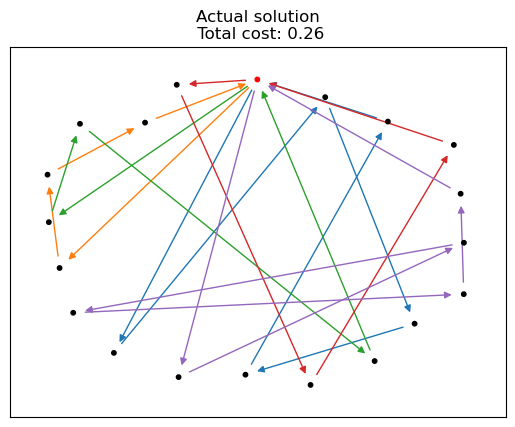

Predicted objective: 1.50331


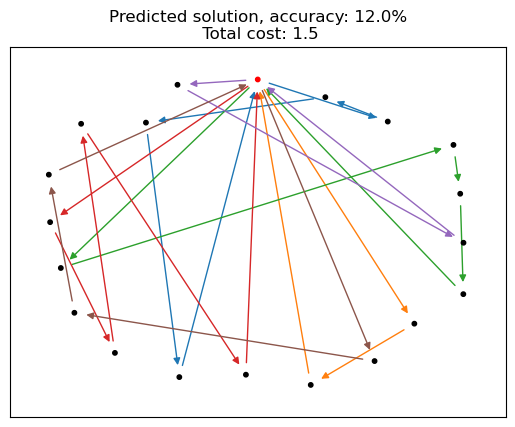

In [22]:
from dfl_vrp.two_stage_model_new import TwoStageModelNew

print('\nTraining 2-stage NEW model...')
model = TwoStageModelNew(vrps_train, vrps_val, vrps_test, lr=LR_2_STAGE, weight_decay=WEIGHT_DECAY)
train_time, _ = timeit(model.train)(num_epochs=NUM_EPOCHS_2_STAGE)
print('Testing 2-stage model NEW...')
two_stage_new_results = after_train(model, train_time, is_two_stage=True)


Training SPO model...


150it [00:08, 17.65it/s]


Epoch 1 / 50 done, mean loss: 0.9571354103088379, validation loss: 11.46856393814087


150it [00:08, 17.40it/s]


Epoch 2 / 50 done, mean loss: 1.0947056261698405, validation loss: 11.913007545471192


150it [00:11, 13.22it/s]


Epoch 3 / 50 done, mean loss: 1.3351221513748168, validation loss: 11.299894905090332


150it [00:10, 13.70it/s]


Epoch 4 / 50 done, mean loss: 1.0576109011967978, validation loss: 11.657085990905761


150it [00:07, 19.65it/s]


Epoch 5 / 50 done, mean loss: 0.72018226146698, validation loss: 10.76946234703064


150it [00:10, 14.64it/s]


Epoch 6 / 50 done, mean loss: 1.0855513016382854, validation loss: 10.386815357208253


150it [00:09, 16.50it/s]


Epoch 7 / 50 done, mean loss: 0.751440327167511, validation loss: 10.909995841979981


150it [00:06, 21.98it/s]


Epoch 8 / 50 done, mean loss: 0.5554084503650665, validation loss: 11.617790222167969
Early stopping at epoch 7
train took: 113.65035796165466 sec
Testing SPO model...
Testing first TEST instance...
Actual objective: 0.26425


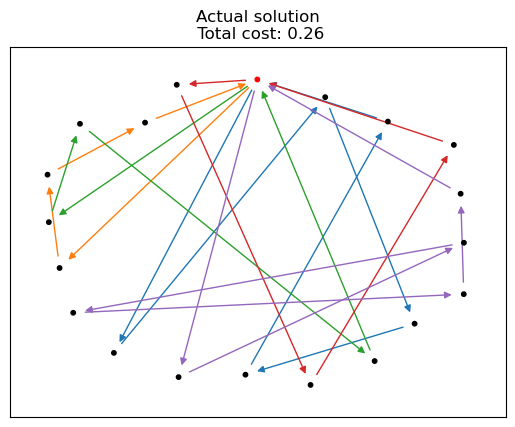

Predicted objective: 2.6288599999999995


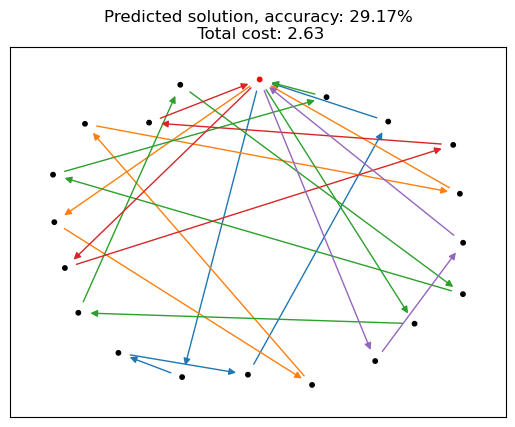

In [23]:
from dfl_vrp.spo_model import SPOModelLinear

print('\nTraining SPO model...')
model = SPOModelLinear(vrps_train, vrps_val, vrps_test, SOLVER_CLASS,
                       lr=LR_SPO, weight_decay=WEIGHT_DECAY, solve_prob=SOLVE_PROB)
train_time, _ = timeit(model.train)(epochs=NUM_EPOCHS_SPO, verbose=False, test_every=1000)
print('Testing SPO model...')
spo_results = after_train(model.cost_model, train_time)

Actual objective: 0.39802


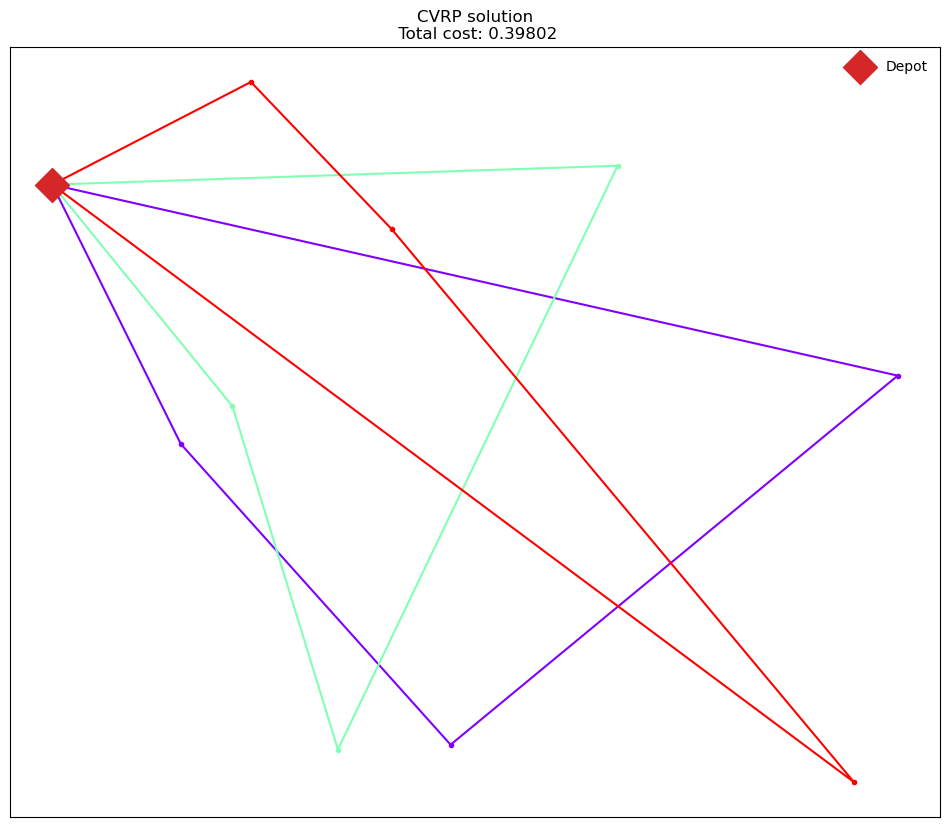

In [80]:
vrp = vrps_train[0]
solver = GurobiSolver(vrp, mip_gap=0, verbose=False, time_limit=5)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver.vrp, solver.get_routes(), solver.get_actual_objective())

VRP actual objective: 0.3761


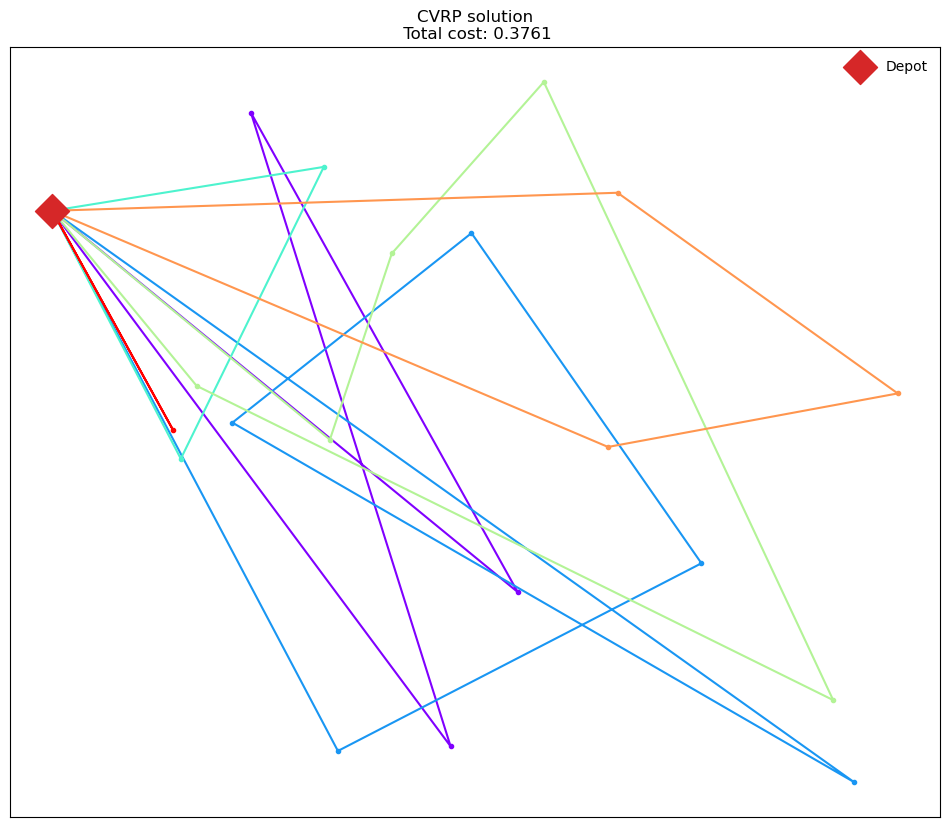

In [76]:
print(f'VRP actual objective: {vrp.actual_obj}')
draw_solution(vrp, vrp.actual_routes, vrp.actual_obj)

Heuristic objective: 0.39802


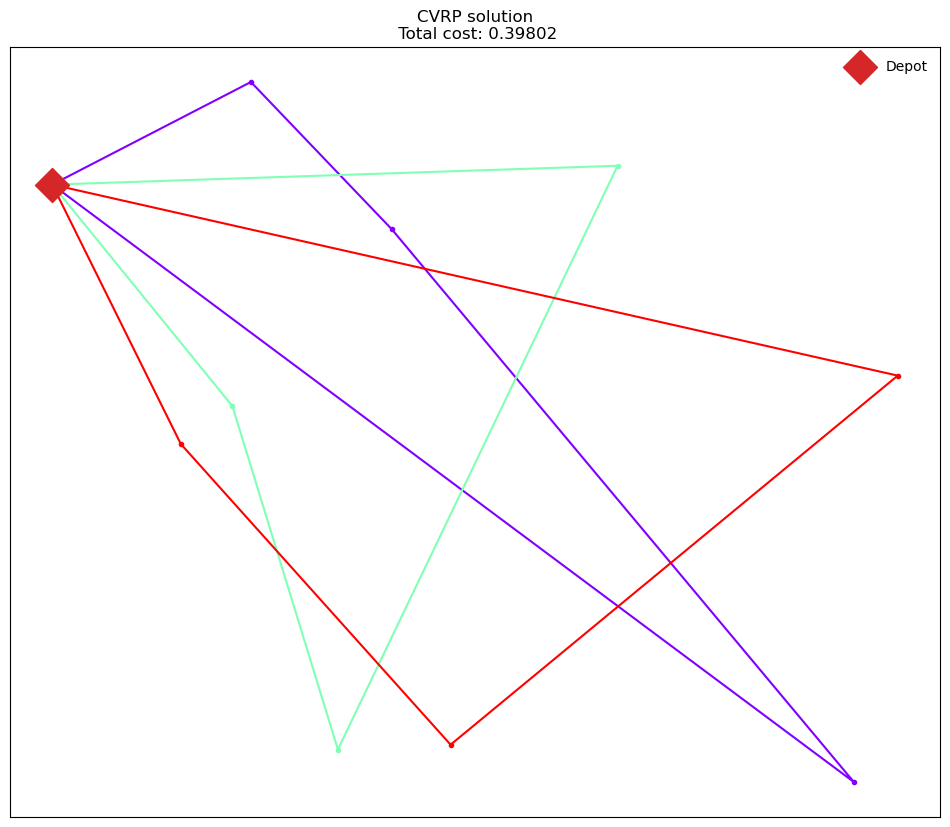

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


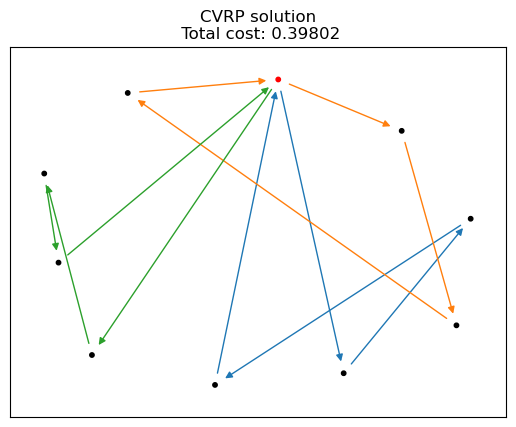

In [81]:
solver = HeuristicSolver(vrp, time_limit=2)
solver.solve()
print(f'Heuristic objective: {solver.get_actual_objective()}')
draw_solution(solver.vrp, solver.get_routes(), solver.get_actual_objective())
draw_solution1(solver.vrp, solver.get_routes(), solver.get_actual_objective())

# 1. 2-stage model

In [ ]:
from dfl_vrp.two_stage_model import TwoStageModel

model = TwoStageModel(vrps_train, vrps_val, vrps_test, lr=1e-3)
model.train(num_epochs=8)
model.test()
test_and_draw(model, vrps_test[0])
test(model, vrps_test, GurobiSolver)

Testing example instance VRP instance: ../data/capacity100/instances10000/nodes20/noise0.2/feat4/instance_1, predicted cost: 0.3044329881668091, actual cost: 0.19788
Drawing actual solution


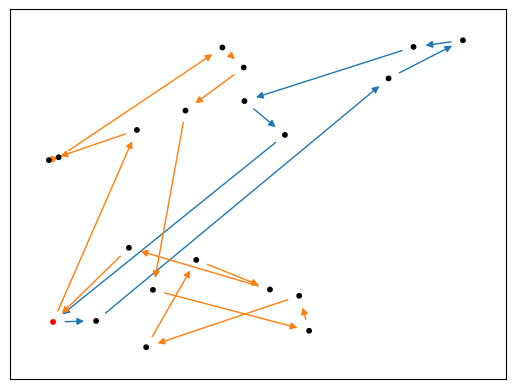

Drawing predicted solution


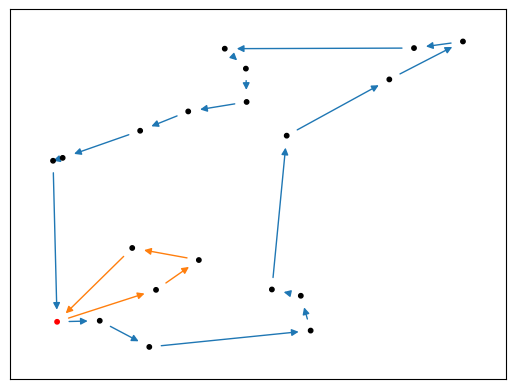

Actual edges (21): [0 -> 9, 0 -> 14, 1 -> 4, 2 -> 12, 3 -> 7, 4 -> 8, 5 -> 13, 6 -> 15, 7 -> 0, 8 -> 18, 9 -> 2, 10 -> 5, 11 -> 3, 12 -> 10, 13 -> 0, 14 -> 19, 15 -> 17, 16 -> 1, 17 -> 11, 18 -> 6, 19 -> 16]
Predicted edges (21): [0 -> 9, 0 -> 18, 1 -> 4, 2 -> 12, 3 -> 13, 4 -> 5, 5 -> 8, 6 -> 15, 7 -> 0, 8 -> 14, 9 -> 17, 10 -> 1, 11 -> 7, 12 -> 10, 13 -> 2, 14 -> 16, 15 -> 3, 16 -> 19, 17 -> 6, 18 -> 11, 19 -> 0]
Correct edges (6): {6 -> 15, 12 -> 10, 7 -> 0, 0 -> 9, 1 -> 4, 2 -> 12}


In [23]:
test(model, vrps_test, GurobiSolver)

In [25]:
from dfl_vrp.spo_model import SPOModel

spo_model = SPOModel(vrps_train, vrps_val, vrps_test, solver_class=GurobiSolver, lr=1e-3, solve_prob=1, weight_decay=0)
spo_model.train(epochs=8, verbose=False, test_every=1)

9it [00:00, 40.34it/s]


Interrupt request received


7500it [10:48, 11.56it/s]


Epoch 1 / 8 done, mean loss: 112.12752979736328, validation loss: 107.90401141357422


100%|██████████| 2000/2000 [01:47<00:00, 18.59it/s]


Accuracy: 0.08026980519480541, cost comparison: 3.6838160773190936, regret: 2.755779880368943


7500it [15:26,  8.10it/s]


Epoch 2 / 8 done, mean loss: 79.75860364176432, validation loss: 119.444599609375


100%|██████████| 2000/2000 [01:57<00:00, 17.07it/s]


Accuracy: 0.08894242424242486, cost comparison: 3.5458184047894363, regret: 2.6140819403689375


1430it [01:48, 13.46it/s]


Interrupt request received

Interrupt request received


1430it [01:48, 13.21it/s]

KeyboardInterrupt



Actual objective: 1.8465699999999998


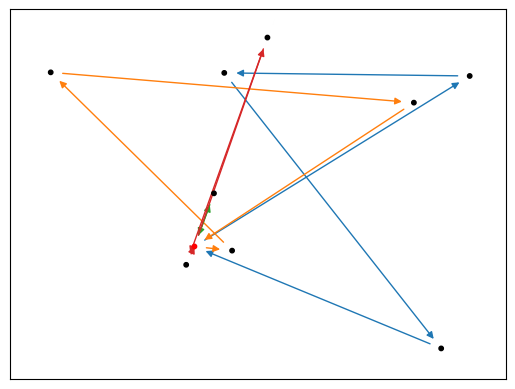

Predicted objective: 2.60664


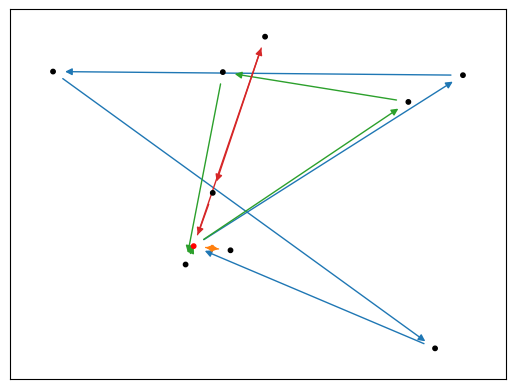

In [11]:
spo_model.cost_model.eval()
vrp = vrps_train[1]
# vrp = vrps_test[0]
costs = spo_model.cost_model(torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32))
# set the predicted edge costs
for i, edge in enumerate(vrp.edges):
    edge.predicted_cost = costs[i].detach().item()

solver = GurobiSolver(vrp)
solver.solve()
print(f'Actual objective: {solver.get_actual_objective()}')
draw_solution(solver)

solver = GurobiSolver(vrp, mode=SolverMode.PRED_COST)
solver.solve()
print(f'Predicted objective: {solver.get_actual_objective()}')
draw_solution(solver)